# Evaluation of solutions

This notebook provides commands used in constructing a smoothed estimate of mutation density using wavelet decomposition (described in Section 3.5), and simulating the distribution of the number of recurrent mutations (using Algorithm 1).

External tools used:

[MAFFT](https://mafft.cbrc.jp/alignment/software/)

[SNP-sites](https://www.sanger.ac.uk/tool/snp-sites/)

The list of problematic sites to mask by De Maio et al (2020) is downloaded as `problematic_sites_sarsCov2.vcf` from [here](https://github.com/W-L/ProblematicSites_SARS-CoV2).

## Data processing

Data from [GISAID](https://www.gisaid.org/) was downloaded on 3 December 2020, filtering for sequences:

- collected between 1 September and 30 November 2020 (all countries);

- marked as complete (>29,900 nucleotides), high coverage and excluding low coverage sequences (>5% ambiguous nucleotides);

giving 60,840 sequences in total. Alignment to the reference sequence (GISAID accession EPI_ISL_402125, GenBank ID MN908947.3) was done using MAFFT with the options
```sh
--auto --thread -1 --keeplength ---preservecase --addfragments
```
All symbols other than 'A, C, T, G' were replaced with 'N'. The resulting multiple alignment file is named  `all_alignment_cleaned.fasta`.

The SNPs were extracted in vcf format using SNP-Sites, and the R script `positions.R` was used to output just the SNP positions to the file `all_snp_positions.txt`:

In [1]:
!snp-sites -v -o all_snp.vcf all_alignment_cleaned.fasta

In [2]:
!Rscript positions.R all_snp.vcf all_positions.txt

The number of variable sites is given by:

In [3]:
!wc -w < all_positions.txt

   14263


We also prepare the reference sequence stored in `ref_seq.fasta` for reading into R:

In [4]:
!awk '/^>/ { print (NR==1 ? "" : RS) $0; next } { printf "%s", $0 } END { printf RS }' ref_seq.fasta > ref_test.txt;
!sed -i .bak 's/./& /g' ref_test.txt;
!sed -i .bak 1d ref_test.txt

## Estimation of mutation density

The resulting list of positions is then read into R, and the vector $\overline{P}$ is created as follows.

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(data.table)))

f <- "all_positions.txt"
snp <- data.table(t(read.table(f, header=FALSE, fill=TRUE, row.names=NULL, sep = " "))) %>%
  rename(position = V1) %>%
  mutate(mut = 1)
filler <- data.frame(position = 1:29903)
snp <- right_join(snp, filler)
snp$mut[is.na(snp$mut)] <- 0
Pbar <- snp$mut

Joining, by = "position"



In [2]:
length(Pbar)

[1] 29903

In [3]:
sum(Pbar==1)

[1] 14263

As wavelet decomposition requires the number of observations to be a power of 2, $\overline{P}$ is padded at the endpoints by reflecting the data:

In [4]:
ext_left <- floor((2^15 - length(Pbar))/2)
ext_right <- length(Pbar) - ceiling((2^15 - length(Pbar))/2) + 1
ExtPbar <- c(rev(Pbar[1:ext_left]), Pbar, rev(Pbar[length(Pbar):ext_right]))

The wavelet decomposition is performed using the `wavethresh` package. The thresholding is carried out using the `EbayesThresh` package which implements the method of Johnstone and Silverman (2005).

In [5]:
suppressWarnings(suppressMessages(library(wavethresh)))
suppressWarnings(suppressMessages(library(EbayesThresh)))

Y <- wd(ExtPbar, filter.number=6, family="DaubLeAsymm")
Y <- ebayesthresh.wavelet(Y, threshrule="soft")
Y <- wr(Y)
Y <- Y[(ext_left+1):(ext_left + length(Pbar))] # Deleting the padding
Ynorm <- Y/sum(Y) # Normalising to sum to 1

A plot of the resulting smoothed estimate is given by

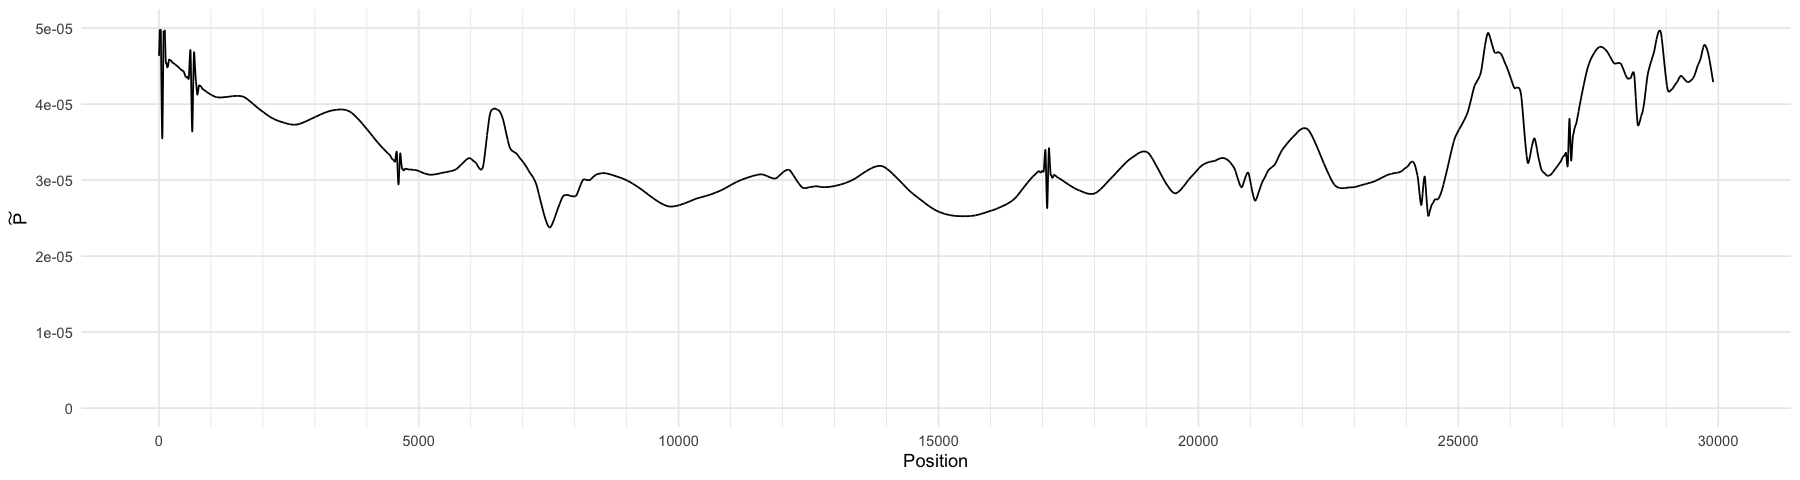

In [6]:
library(latex2exp)
options(repr.plot.width=15, repr.plot.height=4)

g1 <- ggplot(data=data.frame(x=1:29903, y=Ynorm), aes(x=x, y=y)) +
  geom_line() +
  theme_minimal() +
  xlab("Position") + 
  ylab(TeX("$\\widetilde{P}$")) +
  scale_x_continuous(breaks = seq(0,30000,5000), labels = seq(0,30000,5000), minor_breaks=seq(0,30000,1000)) +
  scale_y_continuous(breaks = seq(-0.00001,0.00007, 0.00001), labels = seq(-0.00001,0.00007, 0.00001), minor_breaks=NULL, limits=c(0,0.00005))
g1

We now read in the reference sequence, adjust the estimate $Y$ to take into account base heterogeneity as described in Section 3.5.1, and compute Table 1:

In [7]:
g <- t(read.table("ref_test.txt", header=FALSE, fill=FALSE, row.names=NULL, sep = " ", colClasses="character"))
g[g=="T"] <- "U"
g <- g[g!=""]

snp$type <- g
Adj <- snp %>%
  dplyr::select(c(type,mut)) %>%
  group_by(type) %>%
  summarise(Base_prop = sum(mut),
            Bases = n()) %>%
  ungroup %>%
  mutate(Base_prop = Base_prop/sum(Base_prop)) %>%
  dplyr::select(c(type, Base_prop, Bases))
Adj_table <- data.table(Y = Ynorm, type = snp$type) %>%
  group_by(type) %>%
  mutate(Yprop = sum(Y)) %>%
  ungroup()
Adj_table <- left_join(Adj_table, Adj, by="type") %>%
  mutate(Yadj = Y * (Base_prop/Yprop)) %>%
  mutate(Pos = 1:n()) %>%
  rename(Base = type)
Adj_table %>%
  group_by(Base) %>%
  summarise(genome_by_base = min(Bases)/29903,
            mutations_by_base = min(Base_prop),
            Y_unadjusted = sum(Y),
            Y_adjusted = sum(Yadj)) 

Base,genome_by_base,mutations_by_base,Y_unadjusted,Y_adjusted
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
A,0.2994348,0.2507186,0.2995082,0.2507186
C,0.1836605,0.2725934,0.1854484,0.2725934
G,0.1960673,0.2324195,0.1969596,0.2324195
U,0.3208374,0.2442684,0.3180838,0.2442684


To recreate Figure 2:

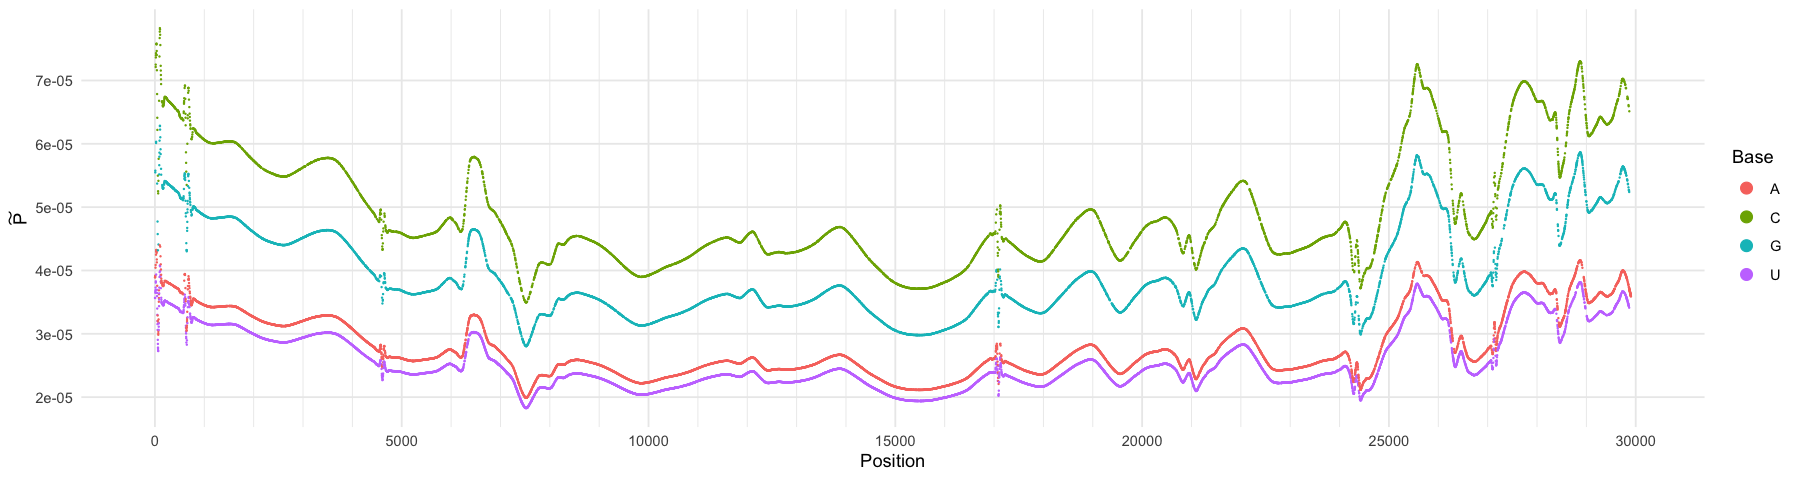

In [8]:
g2 <- ggplot(data=Adj_table, aes(x=Pos, y=Yadj)) +
  geom_point(aes(colour = Base), size=0.01) +
  theme_minimal() +
  xlab("Position") + 
  ylab(TeX("$\\widetilde{P}$")) +
  scale_x_continuous(breaks = seq(0,30000,5000), labels = seq(0,30000,5000), minor_breaks=seq(0,30000,1000)) +
  scale_y_continuous(breaks = seq(-0.00001,0.00007, 0.00001), labels = seq(-0.00001,0.00007, 0.00001), minor_breaks=NULL) +
  guides(colour = guide_legend(override.aes = list(size=3)))
g2

The following functions implement Algorithm 1:

In [9]:
# Algorithm 1
sim <- function(M, m, P) {
  sites <- rep(NA, 10000)
  visited <- sample(1:M, size = m, replace=TRUE, prob=P)
  if(length(unique(visited)) == m) {
    return(m)
  }
  else {
    sites[1:m] <- visited
    for(i in (m+1):10000) {
      visited <- sample(1:M, size = 1, replace = TRUE, prob = P)
      sites[i] <- visited
      if(length(unique(sites[1:i])) == m) {
        return(i)
      }
    }
  }
}

calc <- function(M, m, n, P) {
  results <- rep(NA, n)
  for(i in 1:n) {
    results[i] <- sim(M, m, P)
  }
  return(results - m)
} 

This is used to simulate the distribution of the number of recurrent mutations as follows (the example is only shown for the England dataset, but this is equivalent for the South Africa dataset).

In [10]:
vcf <- fread("problematic_sites_sarsCov2.vcf", check.names=TRUE, skip="#CHROM")
mask <- c(vcf$POS, 12067, 21724, 22992) # also adding multi-allelic sites

Y1 <- Adj_table$Yadj
Y1[mask] <- NA
P <- Y1[!is.na(Y1)]
M <- length(P) # Length of the genome minus number of masked sites
m <- round((363 + 10)*1.1,0) # Adjusted number of variable sites observed
res <- calc(M, m, 10000, P)

To recreate Figure 3 (run with 10,000 iterations in this case):

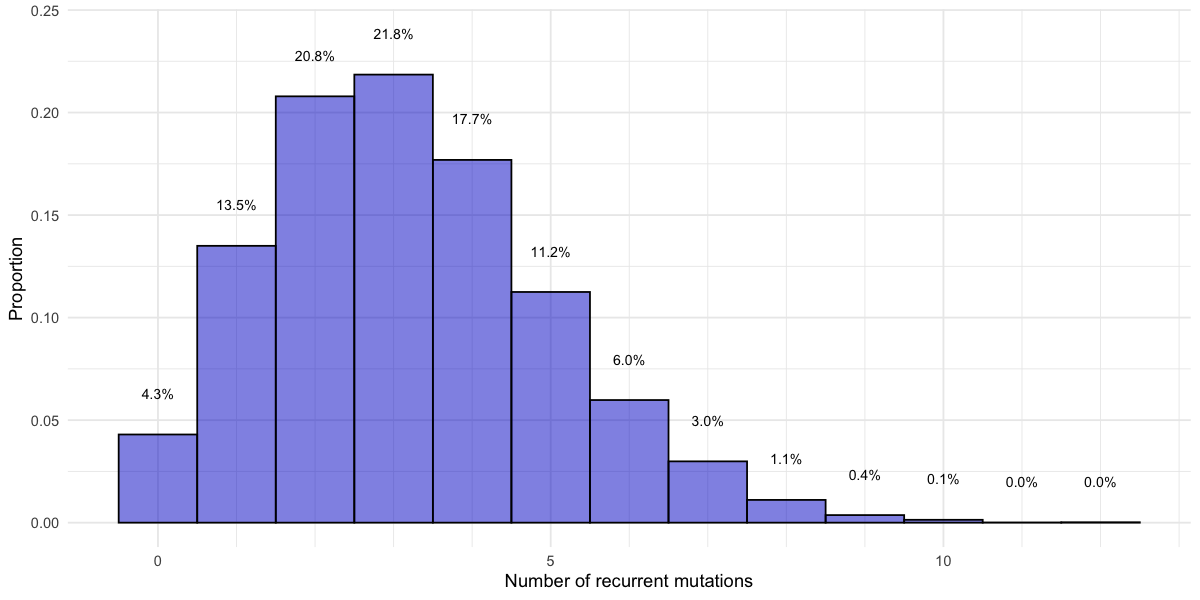

In [11]:
options(repr.plot.width=10, repr.plot.height=5)
g3 <- ggplot(data.frame(x = res), aes(x=x)) + 
  geom_histogram(aes(y=..density..), binwidth=1, colour = "black", fill = "mediumblue", alpha = 0.5) +
  theme_minimal() +
  xlab("Number of recurrent mutations") +
  ylab("Proportion") +
  geom_text(aes( label = scales::percent(..prop.., accuracy = 0.1),
                 y= ..prop..), stat= "count", vjust = "middle", nudge_y=0.02, size=3) +
  scale_x_continuous(breaks = seq(0,15,5), labels = seq(0,15,5), minor_breaks=seq(0,15,1))
g3